# Objective
* 20181225: 
    * Predict stock price in next day using XGBoost
    * Given prices and other features for the last N days, we do prediction for day N+1
    * Here we split 3 years of data into train(60%), dev(20%) and test(20%)
* 20190110 - Diff from StockPricePrediction_v1_xgboost.ipynb:
    * Here we scale the train set to have mean 0 and variance 1, and apply the same transformation to dev and test sets

In [126]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import time

from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook
from xgboost import XGBRegressor
import tqdm

%matplotlib inline

#### Input params ##################
stk_path = "features.csv"
test_size = 0.2                # proportion of dataset to be used as test set
cv_size = 0.2                  # proportion of dataset to be used as cross-validation set
N = 7                          # for feature at day t, we use lags from t-1, t-2, ..., t-N as features

n_estimators = 100             # for the initial model before tuning. default = 100
max_depth = 3                  # for the initial model before tuning. default = 3
learning_rate = 0.1            # for the initial model before tuning. default = 0.1
min_child_weight = 1           # for the initial model before tuning. default = 1
subsample = 1                  # for the initial model before tuning. default = 1
colsample_bytree = 1           # for the initial model before tuning. default = 1
colsample_bylevel = 1          # for the initial model before tuning. default = 1
train_test_split_seed = 111    # 111
model_seed = 100

fontsize = 14
ticklabelsize = 14
####################################

# Load data

In [127]:
df = pd.read_csv(stk_path, sep = ",")
df.drop(labels=["Unnamed: 0"],axis=1,inplace=True)
df=df[["date","open","high","low","close","volume","month","adj_close"]]
'''
# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head()
'''
df.loc[:,"adj_close"]=df.loc[:,"close"]
df.iloc[:,:]

,date,open,high,low,close,volume,month,adj_close
0,2016-01-04,102.61,105.368,102.00,105.35,67649387.0,1,105.35
1,2016-01-05,105.75,105.850,102.41,102.71,55790992.0,1,102.71
2,2016-01-06,100.56,102.370,99.87,100.70,68457388.0,1,100.70
3,2016-01-07,98.68,100.130,96.43,96.45,81094428.0,1,96.45
4,2016-01-08,98.55,99.110,96.76,96.96,70798016.0,1,96.96
...,...,...,...,...,...,...,...,...
1297,2021-03-01,123.75,127.930,122.79,127.79,116307892.0,3,127.79
1298,2021-03-02,128.41,128.720,125.01,125.12,102260945.0,3,125.12
1299,2021-03-03,124.81,125.710,121.84,122.06,112966340.0,3,122.06
1300,2021-03-04,121.75,123.600,118.62,120.13,178154975.0,3,120.13


In [104]:
df1 = pd.read_csv("VTI.csv", sep = ",")
#df.drop(labels=["Unnamed: 0"],axis=1,inplace=True)
#df1=df1[["date","open","high","low","close","volume","month","adj_close"]]

# Convert Date column to datetime
df1.loc[:, 'Date'] = pd.to_datetime(df1['Date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df1.columns = [str(x).lower().replace(' ', '_') for x in df1.columns]

# Get month of each sample
df1['month'] = df1['date'].dt.month

# Sort by datetime
df1.sort_values(by='date', inplace=True, ascending=True)

df1.tail()

#df.loc[:,"adj_close"]=df.loc[:,"close"]
#df.iloc[-200:,:]

,date,open,high,low,close,adj_close,volume,month
750,2018-11-16,139.070007,140.570007,138.820007,140.080002,140.080002,2272300,11
751,2018-11-19,139.830002,139.929993,137.169998,137.649994,137.649994,3481800,11
752,2018-11-20,135.729996,136.619995,134.639999,135.199997,135.199997,4627200,11
753,2018-11-21,136.000000,136.889999,135.750000,135.860001,135.860001,4151300,11
754,2018-11-23,134.919998,135.919998,134.729996,135.130005,135.130005,1300000,11


In [105]:
df=df1.copy()

Text(0, 0.5, 'USD')

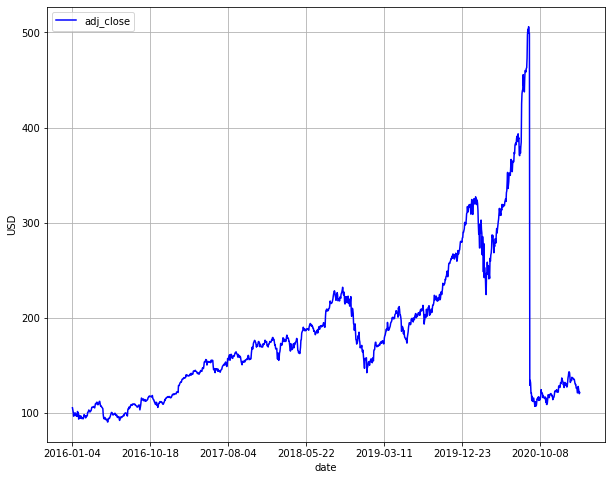

In [128]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

# Split into train, dev and test set

In [129]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train]
cv = df[num_train:num_train+num_cv]
train_cv = df[:num_train+num_cv]
test = df[num_train+num_cv:]

print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 782
num_cv = 260
num_test = 260
train.shape = (782, 8)
cv.shape = (260, 8)
train_cv.shape = (1042, 8)
test.shape = (260, 8)


In [130]:
train

,date,open,high,low,close,volume,month,adj_close
0,2016-01-04,102.61,105.368,102.00,105.35,67649387.0,1,105.35
1,2016-01-05,105.75,105.850,102.41,102.71,55790992.0,1,102.71
2,2016-01-06,100.56,102.370,99.87,100.70,68457388.0,1,100.70
3,2016-01-07,98.68,100.130,96.43,96.45,81094428.0,1,96.45
4,2016-01-08,98.55,99.110,96.76,96.96,70798016.0,1,96.96
...,...,...,...,...,...,...,...,...
777,2019-02-05,172.86,175.080,172.35,174.18,36101628.0,2,174.18
778,2019-02-06,174.65,175.570,172.85,174.24,28239591.0,2,174.24
779,2019-02-07,172.40,173.940,170.34,170.94,31741690.0,2,170.94
780,2019-02-08,168.99,170.660,168.42,170.41,23819966.0,2,170.41


In [131]:
cv

,date,open,high,low,close,volume,month,adj_close
782,2019-02-12,170.10,171.00,169.70,170.89,22283523.0,2,170.89
783,2019-02-13,171.39,172.48,169.92,170.18,22490233.0,2,170.18
784,2019-02-14,169.71,171.26,169.38,170.80,21835747.0,2,170.80
785,2019-02-15,171.25,171.70,169.75,170.42,24626814.0,2,170.42
786,2019-02-19,169.71,171.44,169.49,170.93,18972826.0,2,170.93
...,...,...,...,...,...,...,...,...
1037,2020-02-18,315.36,319.75,314.61,319.00,38190545.0,2,319.00
1038,2020-02-19,320.00,324.57,320.00,323.62,23495991.0,2,323.62
1039,2020-02-20,322.63,324.65,318.21,320.30,25141489.0,2,320.30
1040,2020-02-21,318.62,320.45,310.50,313.05,32426415.0,2,313.05


In [132]:
test

,date,open,high,low,close,volume,month,adj_close
1042,2020-02-25,300.95,302.530,286.13,288.08,57668364.0,2,288.08
1043,2020-02-26,286.53,297.880,286.50,292.65,49678431.0,2,292.65
1044,2020-02-27,281.10,286.000,272.96,273.52,80151381.0,2,273.52
1045,2020-02-28,257.26,278.410,256.37,273.36,106721230.0,2,273.36
1046,2020-03-02,282.28,301.440,277.72,298.81,85349339.0,3,298.81
...,...,...,...,...,...,...,...,...
1297,2021-03-01,123.75,127.930,122.79,127.79,116307892.0,3,127.79
1298,2021-03-02,128.41,128.720,125.01,125.12,102260945.0,3,125.12
1299,2021-03-03,124.81,125.710,121.84,122.06,112966340.0,3,122.06
1300,2021-03-04,121.75,123.600,118.62,120.13,178154975.0,3,120.13


# Scale the train, dev and test set and combine them to do feature engineering

In [133]:
# Converting dataset into x_train and y_train
# Here we only scale the train dataset, and not the entire dataset to prevent information leak
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[['open', 'high', 'low', 'close', 'adj_close', 'volume']])
print("scaler.mean_ = " + str(scaler.mean_))
print("scaler.var_ = " + str(scaler.var_))
print("train_scaled.shape = " + str(train_scaled.shape))

# Convert the numpy array back into pandas dataframe
train_scaled = pd.DataFrame(train_scaled, columns=['open', 'high', 'low', 'close', 'adj_close', 'volume'])
train_scaled[['date', 'month']] = train[['date', 'month']]
print("train_scaled.shape = " + str(train_scaled.shape))
train_scaled.head()

scaler.mean_ = [1.48314172e+02 1.49594985e+02 1.47073773e+02 1.48382858e+02
 1.48382858e+02 3.30861088e+07]
scaler.var_ = [1.38199353e+03 1.41022351e+03 1.35011137e+03 1.37897602e+03
 1.37897602e+03 2.30646008e+14]
train_scaled.shape = (782, 6)
train_scaled.shape = (782, 8)


,open,high,low,close,adj_close,volume,date,month
0,-1.229427,-1.177724,-1.226702,-1.158836,-1.158836,2.275841,2016-01-04,1
1,-1.144962,-1.164888,-1.215544,-1.229928,-1.229928,1.495018,2016-01-05,1
2,-1.284572,-1.257557,-1.284671,-1.284056,-1.284056,2.329045,2016-01-06,1
3,-1.335143,-1.317207,-1.378292,-1.398504,-1.398504,3.161139,2016-01-07,1
4,-1.338640,-1.344368,-1.369311,-1.384771,-1.384771,2.483165,2016-01-08,1


In [134]:
# Do scaling for dev set
cv_scaled  = scaler.transform(cv[['open', 'high', 'low', 'close', 'adj_close', 'volume']])

# Convert the numpy array back into pandas dataframe
cv_scaled = pd.DataFrame(cv_scaled, columns=['open', 'high', 'low', 'close', 'adj_close', 'volume'])
cv_scaled[['date', 'month']] = cv.reset_index()[['date', 'month']]
print("cv_scaled.shape = " + str(cv_scaled.shape))
cv_scaled.head()

cv_scaled.shape = (260, 8)


,open,high,low,close,adj_close,volume,date,month
0,0.586032,0.569996,0.615782,0.606097,0.606097,-0.711303,2019-02-12,2
1,0.620732,0.609407,0.621770,0.586977,0.586977,-0.697692,2019-02-13,2
2,0.575541,0.576919,0.607074,0.603673,0.603673,-0.740787,2019-02-14,2
3,0.616966,0.588636,0.617143,0.593440,0.593440,-0.557008,2019-02-15,2
4,0.575541,0.581712,0.610067,0.607174,0.607174,-0.929298,2019-02-19,2


In [135]:
# Do scaling for test set
test_scaled  = scaler.transform(test[['open', 'high', 'low', 'close', 'adj_close', 'volume']])

# Convert the numpy array back into pandas dataframe
test_scaled = pd.DataFrame(test_scaled, columns=['open', 'high', 'low', 'close', 'adj_close', 'volume'])
test_scaled[['date', 'month']] = test.reset_index()[['date', 'month']]
print("test_scaled.shape = " + str(test_scaled.shape))
test_scaled.head()

test_scaled.shape = (260, 8)


,open,high,low,close,adj_close,volume,date,month
0,4.105854,4.072517,3.784475,3.761917,3.761917,1.618634,2020-02-25,2
1,3.717961,3.948692,3.794545,3.884983,3.884983,1.092532,2020-02-26,2
2,3.571895,3.632339,3.426048,3.369829,3.369829,3.099043,2020-02-27,2
3,2.930607,3.430224,2.974544,3.365520,3.365520,4.848552,2020-02-28,2
4,3.603637,4.043492,3.555593,4.050866,4.050866,3.441306,2020-03-02,3


In [136]:
# Combine back train_scaled, cv_scaled, test_scaled together
df_scaled = pd.concat([train_scaled, cv_scaled, test_scaled], axis=0)
df_scaled.head()

,open,high,low,close,adj_close,volume,date,month
0,-1.229427,-1.177724,-1.226702,-1.158836,-1.158836,2.275841,2016-01-04,1
1,-1.144962,-1.164888,-1.215544,-1.229928,-1.229928,1.495018,2016-01-05,1
2,-1.284572,-1.257557,-1.284671,-1.284056,-1.284056,2.329045,2016-01-06,1
3,-1.335143,-1.317207,-1.378292,-1.398504,-1.398504,3.161139,2016-01-07,1
4,-1.338640,-1.344368,-1.369311,-1.384771,-1.384771,2.483165,2016-01-08,1


# Feature Engineering

We will generate the following features:
* Mean 'adj_close' of each month
* Difference between high and low of each day
* Difference between open and close of each day
* Mean volume of each month

In [137]:
# Get difference between high and low of each day
df_scaled['range_hl'] = df_scaled['high'] - df_scaled['low']
df_scaled.drop(['high', 'low'], axis=1, inplace=True)

# Get difference between open and close of each day
df_scaled['range_oc'] = df_scaled['open'] - df_scaled['close']
df_scaled.drop(['open', 'close'], axis=1, inplace=True)

df_scaled.head()

,adj_close,volume,date,month,range_hl,range_oc
0,-1.158836,2.275841,2016-01-04,1,0.048979,-0.070592
1,-1.229928,1.495018,2016-01-05,1,0.050655,0.084966
2,-1.284056,2.329045,2016-01-06,1,0.027113,-0.000516
3,-1.398504,3.161139,2016-01-07,1,0.061085,0.063362
4,-1.384771,2.483165,2016-01-08,1,0.024943,0.046131


Now we use lags up to N number of days to use as features.

In [138]:
# Add a column 'order_day' to indicate the order of the rows by date
df_scaled['order_day'] = [x for x in list(range(len(df_scaled)))]

# merging_keys
merging_keys = ['order_day']

# List of columns that we will use to create lags
lag_cols = ['adj_close', 'range_hl', 'range_oc', 'volume']
lag_cols

['adj_close', 'range_hl', 'range_oc', 'volume']

In [139]:
shift_range = [x+1 for x in range(N)]

for shift in tqdm.notebook.tqdm(shift_range):
    train_shift = df_scaled[merging_keys + lag_cols].copy()
    
    # E.g. order_day of 0 becomes 1, for shift = 1.
    # So when this is merged with order_day of 1 in df_scaled, this will represent lag of 1.
    train_shift['order_day'] = train_shift['order_day'] + shift
    
    foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
    train_shift = train_shift.rename(columns=foo)

    df_scaled = pd.merge(df_scaled, train_shift, on=merging_keys, how='left') #.fillna(0)
    
del train_shift

# Remove the first N rows which contain NaNs
df_scaled = df_scaled[N:]
    
df_scaled.head()

  0%|          | 0/7 [00:00<?, ?it/s]

,adj_close,volume,date,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,...,range_oc_lag_5,volume_lag_5,adj_close_lag_6,range_hl_lag_6,range_oc_lag_6,volume_lag_6,adj_close_lag_7,range_hl_lag_7,range_oc_lag_7,volume_lag_7
7,-1.373191,1.932801,2016-01-13,1,0.065635,0.082164,7,-1.303983,0.010411,0.019143,...,-0.000516,2.329045,-1.229928,0.050655,0.084966,1.495018,-1.158836,0.048979,-0.070592,2.275841
8,-1.315832,1.980901,2016-01-14,1,0.089184,-0.038679,8,-1.373191,0.065635,0.082164,...,0.063362,3.161139,-1.284056,0.027113,-0.000516,2.329045,-1.229928,0.050655,0.084966,1.495018
9,-1.380193,3.078138,2016-01-15,1,0.025764,-0.021661,9,-1.315832,0.089184,-0.038679,...,0.046131,2.483165,-1.398504,0.061085,0.063362,3.161139,-1.284056,0.027113,-0.000516,2.329045
10,-1.392849,1.317021,2016-01-19,1,0.046985,0.050443,10,-1.380193,0.025764,-0.021661,...,0.015150,1.096545,-1.384771,0.024943,0.046131,2.483165,-1.398504,0.061085,0.063362,3.161139
11,-1.389349,2.584330,2016-01-20,1,0.091336,-0.042095,11,-1.392849,0.046985,0.050443,...,0.019143,1.058016,-1.342492,0.007826,0.015150,1.096545,-1.384771,0.024943,0.046131,2.483165


In [140]:
df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1295 entries, 7 to 1301
Data columns (total 35 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   adj_close        1295 non-null   float64
 1   volume           1295 non-null   float64
 2   date             1295 non-null   object 
 3   month            1295 non-null   int64  
 4   range_hl         1295 non-null   float64
 5   range_oc         1295 non-null   float64
 6   order_day        1295 non-null   int64  
 7   adj_close_lag_1  1295 non-null   float64
 8   range_hl_lag_1   1295 non-null   float64
 9   range_oc_lag_1   1295 non-null   float64
 10  volume_lag_1     1295 non-null   float64
 11  adj_close_lag_2  1295 non-null   float64
 12  range_hl_lag_2   1295 non-null   float64
 13  range_oc_lag_2   1295 non-null   float64
 14  volume_lag_2     1295 non-null   float64
 15  adj_close_lag_3  1295 non-null   float64
 16  range_hl_lag_3   1295 non-null   float64
 17  range_oc_lag_3

In [141]:
# # Get mean of adj_close of each month
# df_gb = df.groupby(['month'], as_index=False).agg({'adj_close':'mean'})
# df_gb = df_gb.rename(columns={'adj_close':'adj_close_mean'})
# df_gb

# # Merge to main df
# df = df.merge(df_gb, 
#               left_on=['month'], 
#               right_on=['month'],
#               how='left').fillna(0)

# # Merge to main df
# shift_range = [x+1 for x in range(2)]

# for shift in tqdm_notebook(shift_range):
#     train_shift = df[merging_keys + lag_cols].copy()
    
#     # E.g. order_day of 0 becomes 1, for shift = 1.
#     # So when this is merged with order_day of 1 in df, this will represent lag of 1.
#     train_shift['order_day'] = train_shift['order_day'] + shift
    
#     foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
#     train_shift = train_shift.rename(columns=foo)

#     df = pd.merge(df, train_shift, on=merging_keys, how='left') #.fillna(0)
    
# del train_shift
    
# df

In [142]:
# # Get mean of volume of each month
# df_gb = df.groupby(['month'], as_index=False).agg({'volume':'mean'})
# df_gb = df_gb.rename(columns={'volume':'volume_mean'})
# df_gb

# # Merge to main df
# df = df.merge(df_gb, 
#               left_on=['month'], 
#               right_on=['month'],
#               how='left').fillna(0)

# df.head()

# Split the scaled features back into train, dev and test set

In [143]:
features = [
"adj_close_lag_1",
"range_hl_lag_1",
"range_oc_lag_1",
"volume_lag_1",
"adj_close_lag_2",
"range_hl_lag_2",
"range_oc_lag_2",
"volume_lag_2",
"adj_close_lag_3",
"range_hl_lag_3",
"range_oc_lag_3",
"volume_lag_3",
"adj_close_lag_4",
"range_hl_lag_4",
"range_oc_lag_4",
"volume_lag_4",
"adj_close_lag_5",
"range_hl_lag_5",
"range_oc_lag_5",
"volume_lag_5",
"adj_close_lag_6",
"range_hl_lag_6",
"range_oc_lag_6",
"volume_lag_6",
"adj_close_lag_7",
"range_hl_lag_7",
"range_oc_lag_7",
"volume_lag_7"
]

target = "adj_close"

# Split into train, cv, and test
train = df_scaled[:num_train]
cv = df_scaled[num_train:num_train+num_cv]
train_cv = df_scaled[:num_train+num_cv]
test = df_scaled[num_train+num_cv:]

# Split into X and y
X_train = train[features]
y_train = train[target]
X_cv = cv[features]
y_cv = cv[target]
X_train_cv = train_cv[features]
y_train_cv = train_cv[target]
X_sample = test[features]
y_sample = test[target]
print("X_train.shape = " + str(X_train.shape))
print("y_train.shape = " + str(y_train.shape))
print("X_cv.shape = " + str(X_cv.shape))
print("y_cv.shape = " + str(y_cv.shape))
print("X_train_cv.shape = " + str(X_train_cv.shape))
print("y_train_cv.shape = " + str(y_train_cv.shape))
print("X_sample.shape = " + str(X_sample.shape))
print("y_sample.shape = " + str(y_sample.shape))

X_train.shape = (782, 28)
y_train.shape = (782,)
X_cv.shape = (260, 28)
y_cv.shape = (260,)
X_train_cv.shape = (1042, 28)
y_train_cv.shape = (1042,)
X_sample.shape = (253, 28)
y_sample.shape = (253,)


In [144]:
train

,adj_close,volume,date,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,...,range_oc_lag_5,volume_lag_5,adj_close_lag_6,range_hl_lag_6,range_oc_lag_6,volume_lag_6,adj_close_lag_7,range_hl_lag_7,range_oc_lag_7,volume_lag_7
7,-1.373191,1.932801,2016-01-13,1,0.065635,0.082164,7,-1.303983,0.010411,0.019143,...,-0.000516,2.329045,-1.229928,0.050655,0.084966,1.495018,-1.158836,0.048979,-0.070592,2.275841
8,-1.315832,1.980901,2016-01-14,1,0.089184,-0.038679,8,-1.373191,0.065635,0.082164,...,0.063362,3.161139,-1.284056,0.027113,-0.000516,2.329045,-1.229928,0.050655,0.084966,1.495018
9,-1.380193,3.078138,2016-01-15,1,0.025764,-0.021661,9,-1.315832,0.089184,-0.038679,...,0.046131,2.483165,-1.398504,0.061085,0.063362,3.161139,-1.284056,0.027113,-0.000516,2.329045
10,-1.392849,1.317021,2016-01-19,1,0.046985,0.050443,10,-1.380193,0.025764,-0.021661,...,0.015150,1.096545,-1.384771,0.024943,0.046131,2.483165,-1.398504,0.061085,0.063362,3.161139
11,-1.389349,2.584330,2016-01-20,1,0.091336,-0.042095,11,-1.392849,0.046985,0.050443,...,0.019143,1.058016,-1.342492,0.007826,0.015150,1.096545,-1.384771,0.024943,0.046131,2.483165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
784,0.603673,-0.740787,2019-02-14,2,-0.030154,-0.028132,784,0.586977,-0.012363,0.033755,...,0.040458,-0.088524,0.696309,-0.009821,0.012116,-0.319122,0.694694,-0.009261,-0.034419,0.198559
785,0.593440,-0.557008,2019-02-15,2,-0.028507,0.023526,785,0.603673,-0.030154,-0.028132,...,-0.036998,-0.610135,0.607443,0.015085,0.040458,-0.088524,0.696309,-0.009821,0.012116,-0.319122
786,0.607174,-0.929298,2019-02-19,2,-0.028355,-0.031633,786,0.593440,-0.028507,0.023526,...,0.044806,-0.796251,0.593171,-0.020005,-0.036998,-0.610135,0.607443,0.015085,0.040458,-0.088524
787,0.636796,-0.459059,2019-02-20,2,-0.019115,-0.021444,787,0.607174,-0.028355,-0.031633,...,-0.020065,-0.711303,0.566780,-0.027948,0.044806,-0.796251,0.593171,-0.020005,-0.036998,-0.610135


# EDA

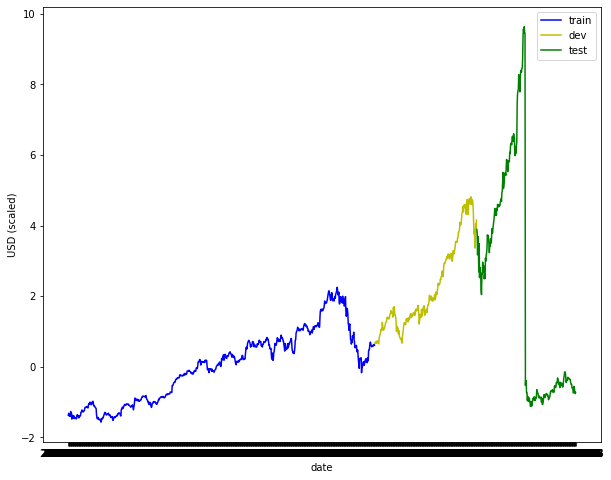

In [145]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
'''
ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD (scaled)")
'''
plt.plot(train["date"], train['adj_close'], 'b-')
plt.plot(cv["date"], cv['adj_close'], 'y-')
plt.plot(test["date"], test['adj_close'], 'g-')
plt.legend(['train', 'dev', 'test'])
plt.xlabel("date")
plt.ylabel("USD (scaled)")
plt.show()

# Train the model using XGBoost

In [146]:
# Create the model
model = XGBRegressor(seed=model_seed,
                      n_estimators=n_estimators,
                      max_depth=max_depth,
                      learning_rate=learning_rate,
                      min_child_weight=min_child_weight)

# Train the regressor
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=100,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=100,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

# Predict on train set

In [147]:
# Do prediction on train set
est = model.predict(X_train)

# Calculate RMSE
math.sqrt(mean_squared_error(y_train, est))

0.03878681615362082

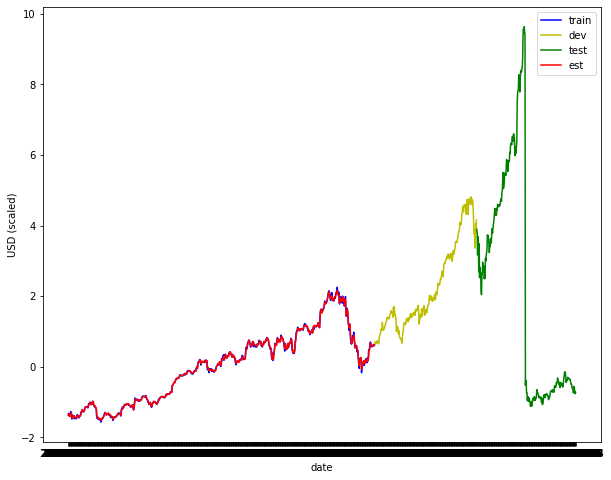

In [148]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'date': train['date']})
'''
ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'est'])
ax.set_xlabel("date")
ax.set_ylabel("USD (scaled)")
'''

plt.plot(train["date"], train['adj_close'], 'b-')
plt.plot(cv["date"], cv['adj_close'], 'y-')
plt.plot(test["date"], test['adj_close'], 'g-')
plt.plot(est_df["date"], est_df['est'], 'r-')
plt.legend(['train', 'dev', 'test', 'est'])
plt.xlabel("date")
plt.ylabel("USD (scaled)")
plt.show()

# Predict on dev set

In [149]:
# Do prediction on test set
est = model.predict(X_cv)

# Calculate RMSE
math.sqrt(mean_squared_error(y_cv, est))

1.064144063695214

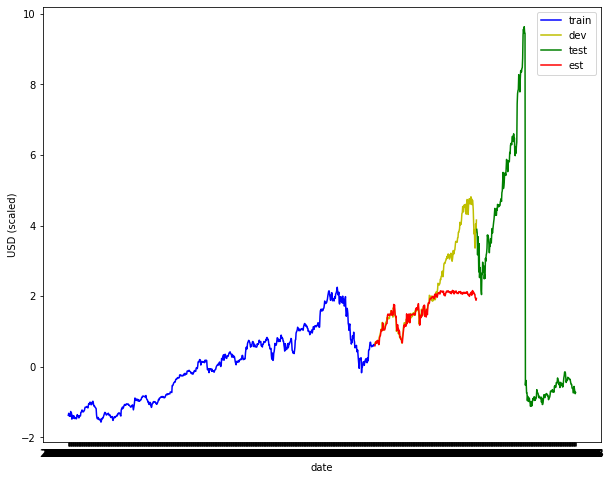

In [150]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'y_cv': y_cv,
                       'date': cv['date']})
'''
ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'est'])
ax.set_xlabel("date")
ax.set_ylabel("USD (scaled)")
'''

plt.plot(train["date"], train['adj_close'], 'b-')
plt.plot(cv["date"], cv['adj_close'], 'y-')
plt.plot(test["date"], test['adj_close'], 'g-')
plt.plot(est_df["date"], est_df['est'], 'r-')
plt.legend(['train', 'dev', 'test', 'est'])
plt.xlabel("date")
plt.ylabel("USD (scaled)")
plt.show()

# Findings
* Doesn't work well
* Likely because the model was trained on prices below ~1.7 and so when it saw prices above 1.7 for the dev set, it could not generalize well